<a href="https://colab.research.google.com/github/ashimakeshava/NMA_marmots/blob/master/functionsForBinning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:


#@title Data retrieval
import os, requests
import numpy as np
from matplotlib import pyplot as plt 
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



#@title Data loading


alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]


(array([3., 4., 4., 7., 3., 3., 5., 5., 4., 1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

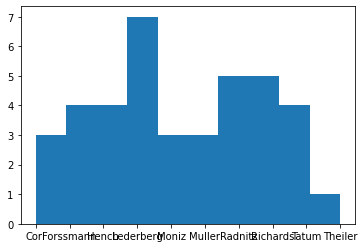

In [49]:

def findIndex(time):
    """
  find the index of a time [s] represented in the spike-bins. As we know, that 
  the bin-width is 10ms, the index can be aproximated as the time devided by the bin-width.
  As we want to use it as an index, we need the return to be an int.

  Args:
    time (float)    : time in seconds

  Returns:
    (int)          : index of the responsible time bin

  """
  index = int(time/0.01) 
  return index

def binData(dat,key, start='stim_onset', stop='response_time'):
    """
  Reconstruct the data based on the top K components.

  Args:
    dat (dictionary) : dict for one session
    key (string)     : new key, that the resulting binned times are associated to
    start (string)   : key defining the stratpoint or points
    stop (string)    : key defig the endpoints

  Returns:
    dat(ditionary)   : dict for one session expanded by the specified time-frame
                        dat[key] list with len = # trials, each entry (bins per neuron)

  """
  # bins = []
  dat[key] = [0]*dat['spks'].shape[1]   # create list initiallized with 0s of the length # trials
  for trial in range(dat['spks'].shape[1]):
    if start == 'stim_onset':
      indexStart = findIndex(dat[start])
    else:
      indexStart = findIndex(dat[start][trial])
    if stop == 'stim_onset':
      indexStop = findIndex(dat[stop])
    else:
      indexStop = findIndex(dat[stop][trial])


    if indexStop<250:                    # just to top the possible index
      bin = dat['spks'][:,trial,indexStart:indexStop]
    else:
      bin = dat['spks'][:,trial,indexStart:249]
    dat[key][trial]= bin                 #: assign the spiketimes to the trial 

  return dat


def averagedRewHist(dat, window):
  padded_stim = np.concatenate([np.zeros(window - 1), dat['feedback_type']])
  dat['averagedReward'] = [0]*len(dat['feedback_type'])
  for i in range(len(dat['feedback_type'])):
    dat['averagedReward'][i] = np.mean(padded_stim[i:i+window])
  return dat



dat = binData(alldat[12], 'choicePeriod')
